In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data Preparation
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Create a subset with few samples per class
np.random.seed(42)
num_samples_per_class = 10
subset_indices = []
for class_label in range(10):
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices = np.random.choice(class_indices, size=num_samples_per_class, replace=False)
    subset_indices.extend(selected_indices)
subset_images = train_images[subset_indices]
subset_labels = train_labels[subset_indices]


170498071/170498071 [==============================] - 2s 0us/step


In [3]:
# Model Architecture -ResNet-18
def residual_block(x, filters, kernel_size=3, stride=1):
    identity = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    if stride != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding="same")(identity)
        identity = layers.BatchNormalization()(identity)
    x = layers.add([x, identity])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    num_blocks_list = [2, 2, 2, 2]
    filters_list = [64, 128, 256, 512]

    for num_blocks, filters in zip(num_blocks_list, filters_list):
        for _ in range(num_blocks):
            stride = 1 if filters == 64 else 2
            x = residual_block(x, filters, stride=stride)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

In [4]:
input_shape = (32, 32, 3)
num_classes = 20
model = build_resnet18(input_shape, num_classes)

# Training
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(subset_images, subset_labels, epochs=10, batch_size=2)


Epoch 1/10
50/50 [==============================] - 10s 126ms/step - loss: 3.3421 - accuracy: 0.0900
Epoch 2/10
50/50 [==============================] - 6s 124ms/step - loss: 3.2776 - accuracy: 0.0500
Epoch 3/10
50/50 [==============================] - 6s 127ms/step - loss: 3.0232 - accuracy: 0.1200
Epoch 4/10
50/50 [==============================] - 5s 108ms/step - loss: 3.0860 - accuracy: 0.0900
Epoch 5/10
50/50 [==============================] - 6s 128ms/step - loss: 3.1210 - accuracy: 0.0500
Epoch 6/10
50/50 [==============================] - 5s 108ms/step - loss: 3.0545 - accuracy: 0.0700
Epoch 7/10
50/50 [==============================] - 6s 117ms/step - loss: 3.3753 - accuracy: 0.0700
Epoch 8/10
50/50 [==============================] - 6s 120ms/step - loss: 3.3170 - accuracy: 0.1000
Epoch 9/10
50/50 [==============================] - 6s 113ms/step - loss: 3.1937 - accuracy: 0.0900
Epoch 10/10
50/50 [==============================] - 6s 121ms/step - loss: 2.9493 - accuracy: 0.170

In [6]:
# Test Performance
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc:.2f}")

313/313 - 15s - loss: 3.6465 - accuracy: 0.1169 - 15s/epoch - 49ms/step
Test accuracy: 0.12


Layer: conv2d, Weight Magnitude: 123.1426


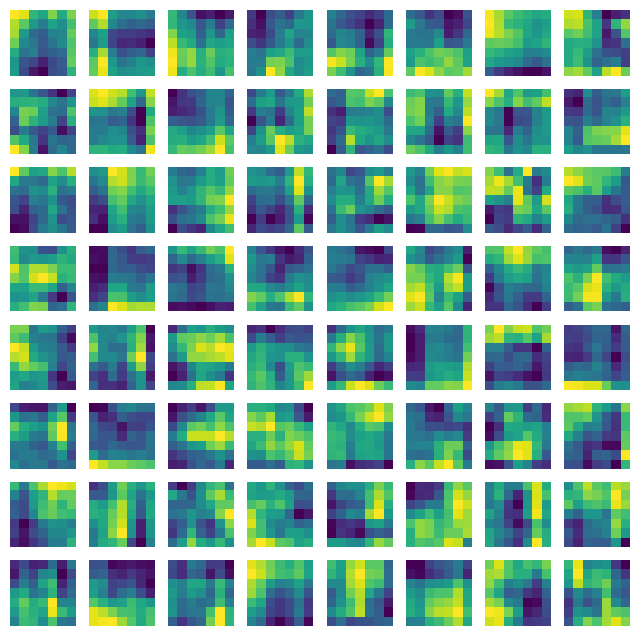

Layer: conv2d_1, Weight Magnitude: 46.5700


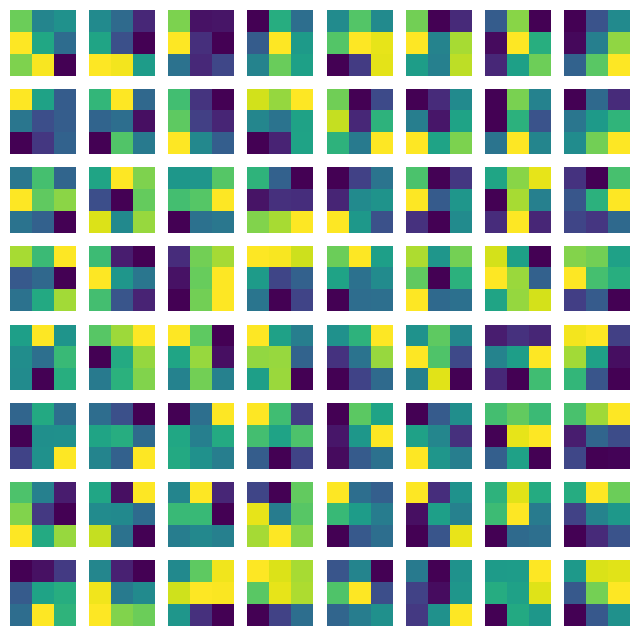

Layer: conv2d_2, Weight Magnitude: 39.0268


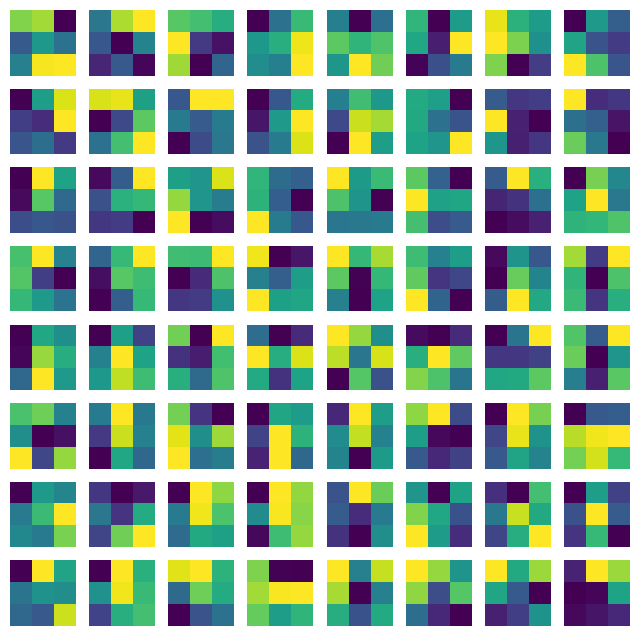

Layer: conv2d_3, Weight Magnitude: 33.7001


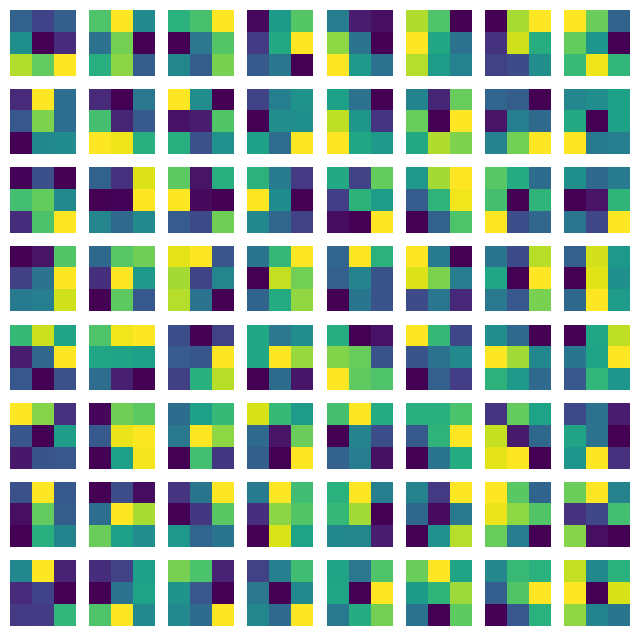

Layer: conv2d_4, Weight Magnitude: 29.6488


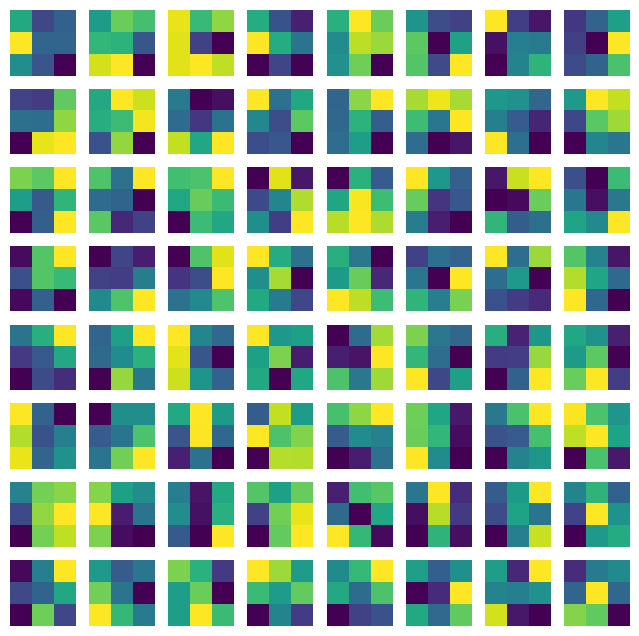

Layer: conv2d_5, Weight Magnitude: 39.5613


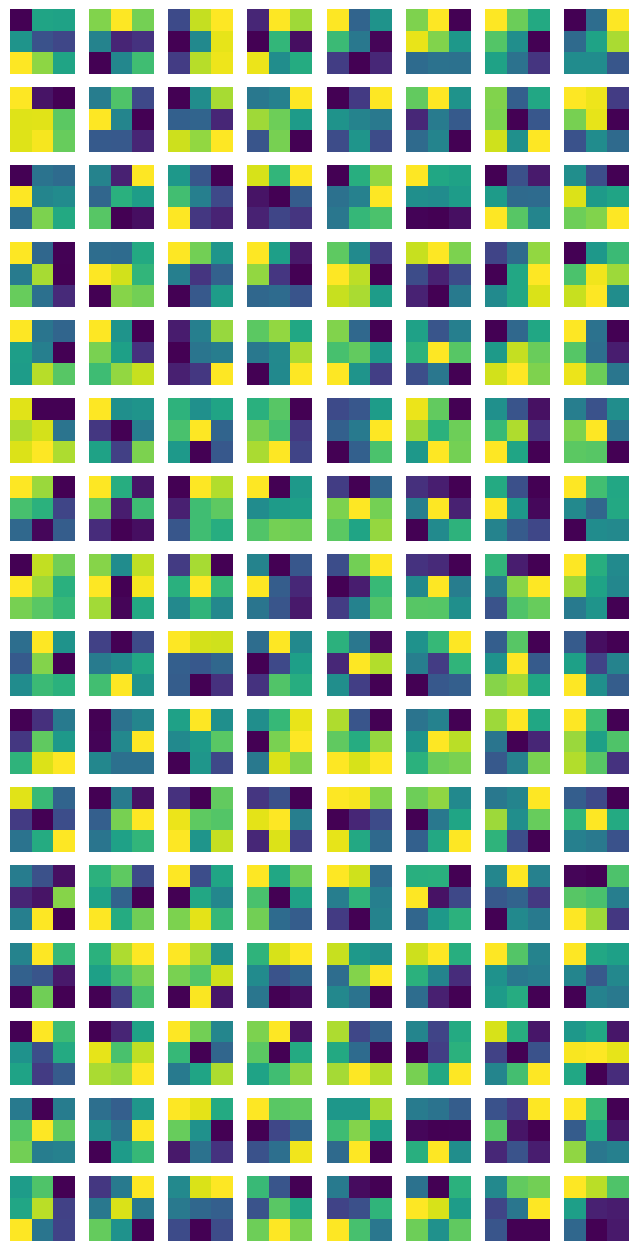

Layer: conv2d_6, Weight Magnitude: 38.5554


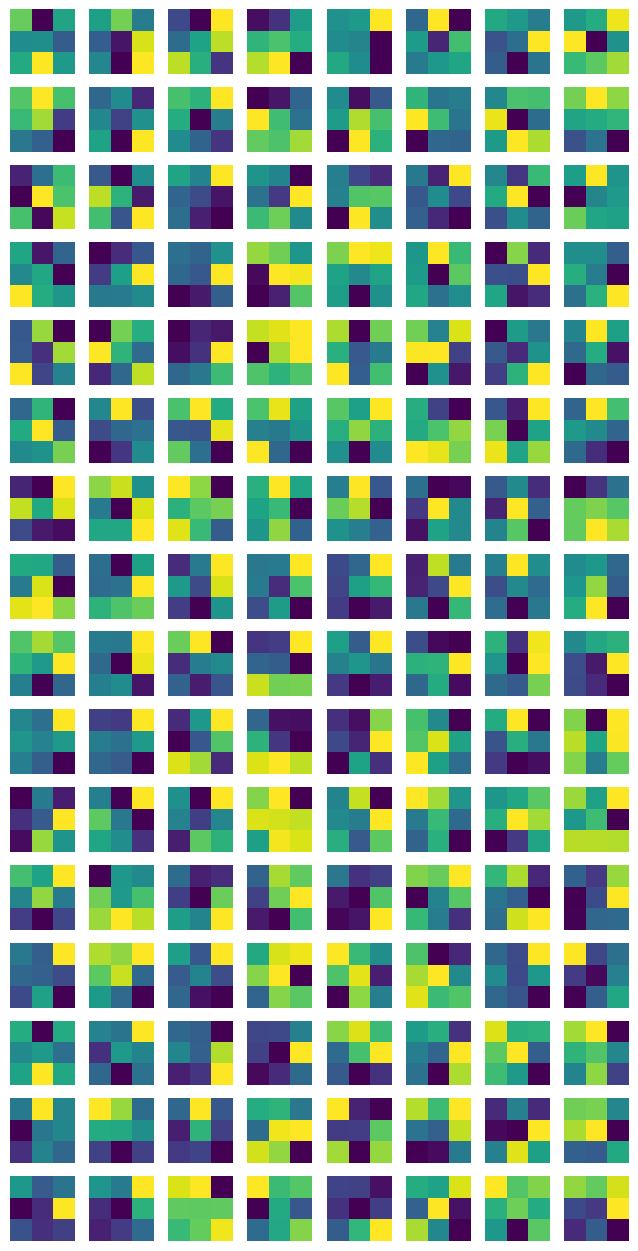

Layer: conv2d_7, Weight Magnitude: 16.2108


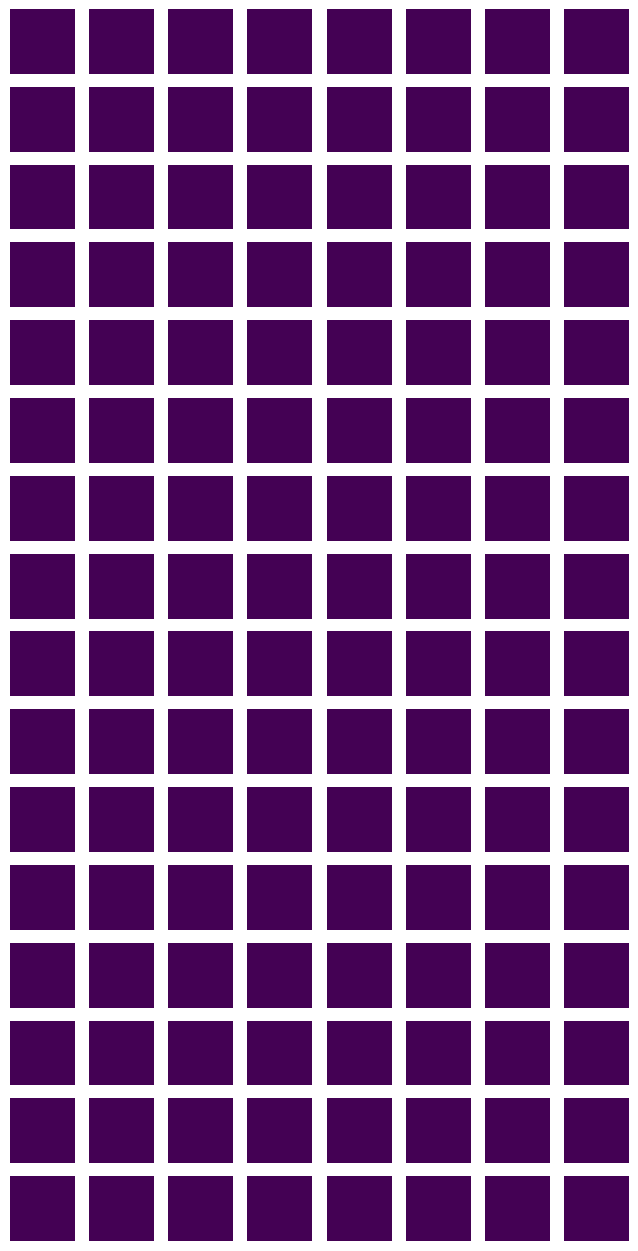

Layer: conv2d_8, Weight Magnitude: 35.3336


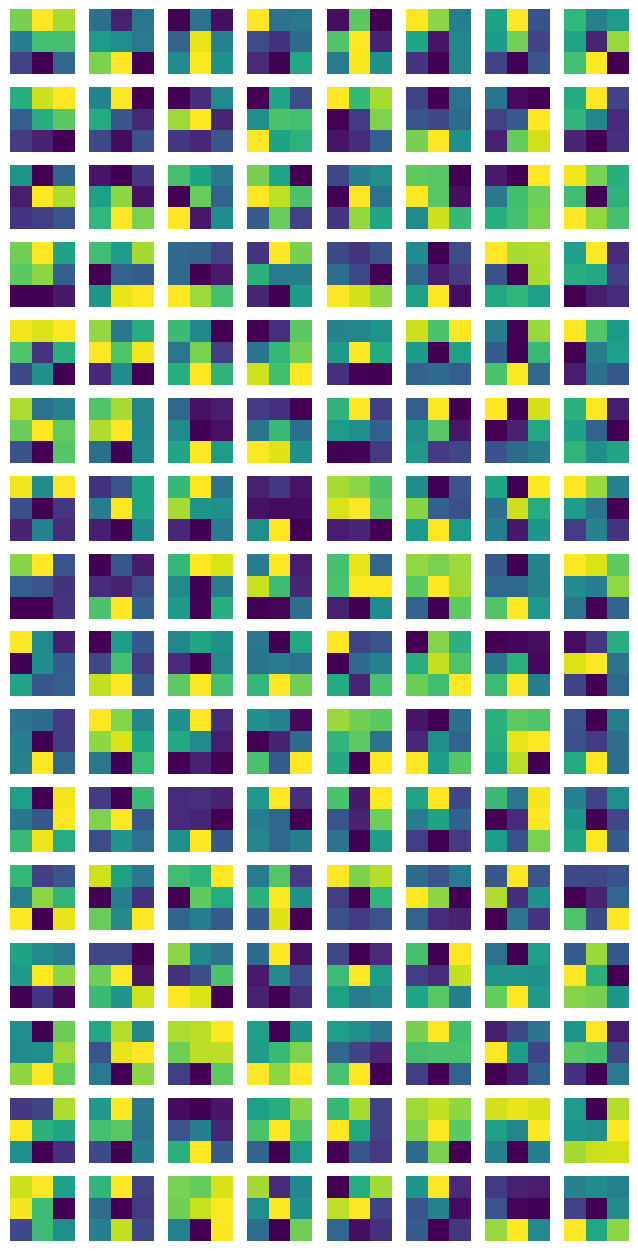

Layer: conv2d_9, Weight Magnitude: 29.7999


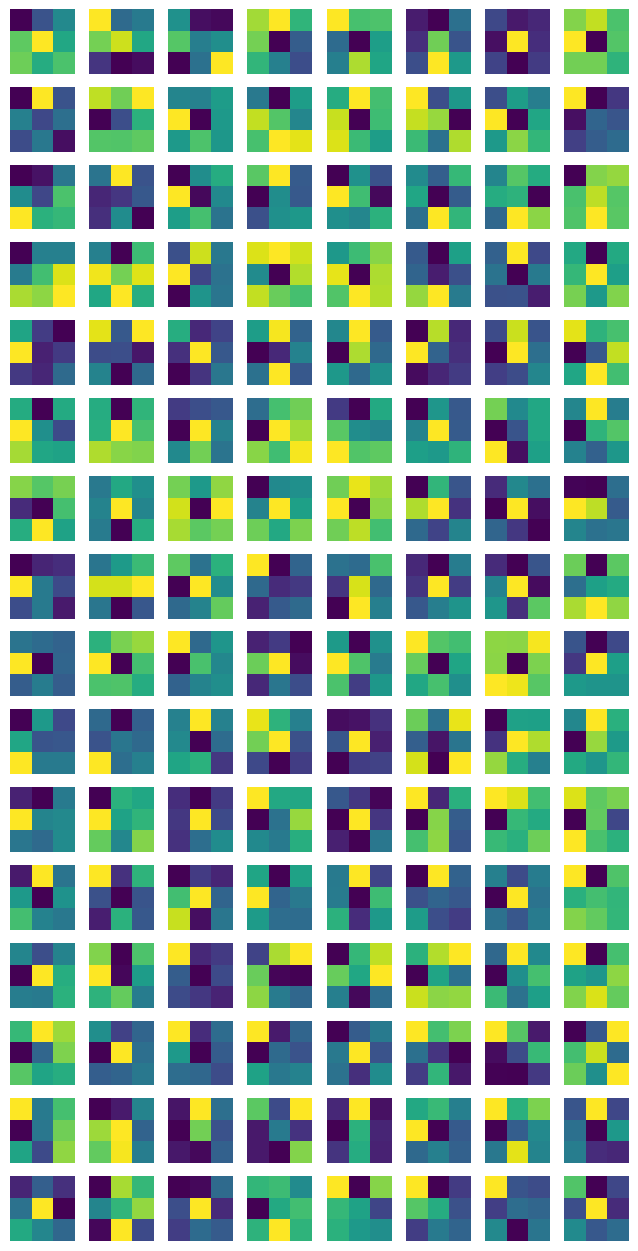

Layer: conv2d_10, Weight Magnitude: 19.0714


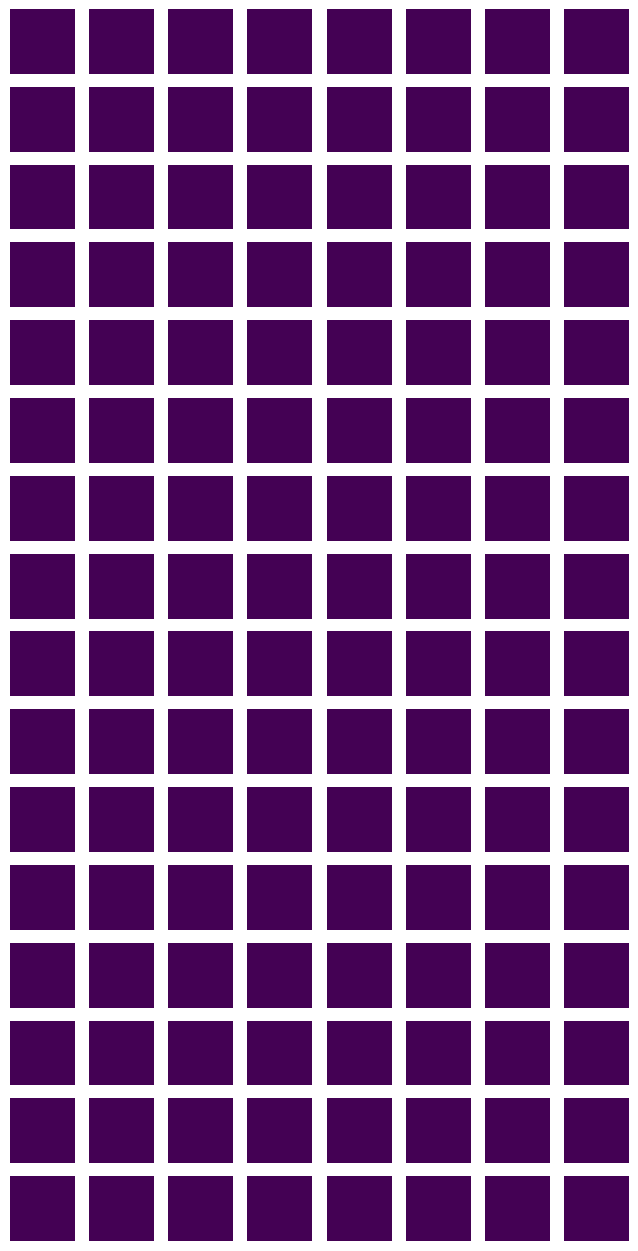

Layer: conv2d_11, Weight Magnitude: 64.2100


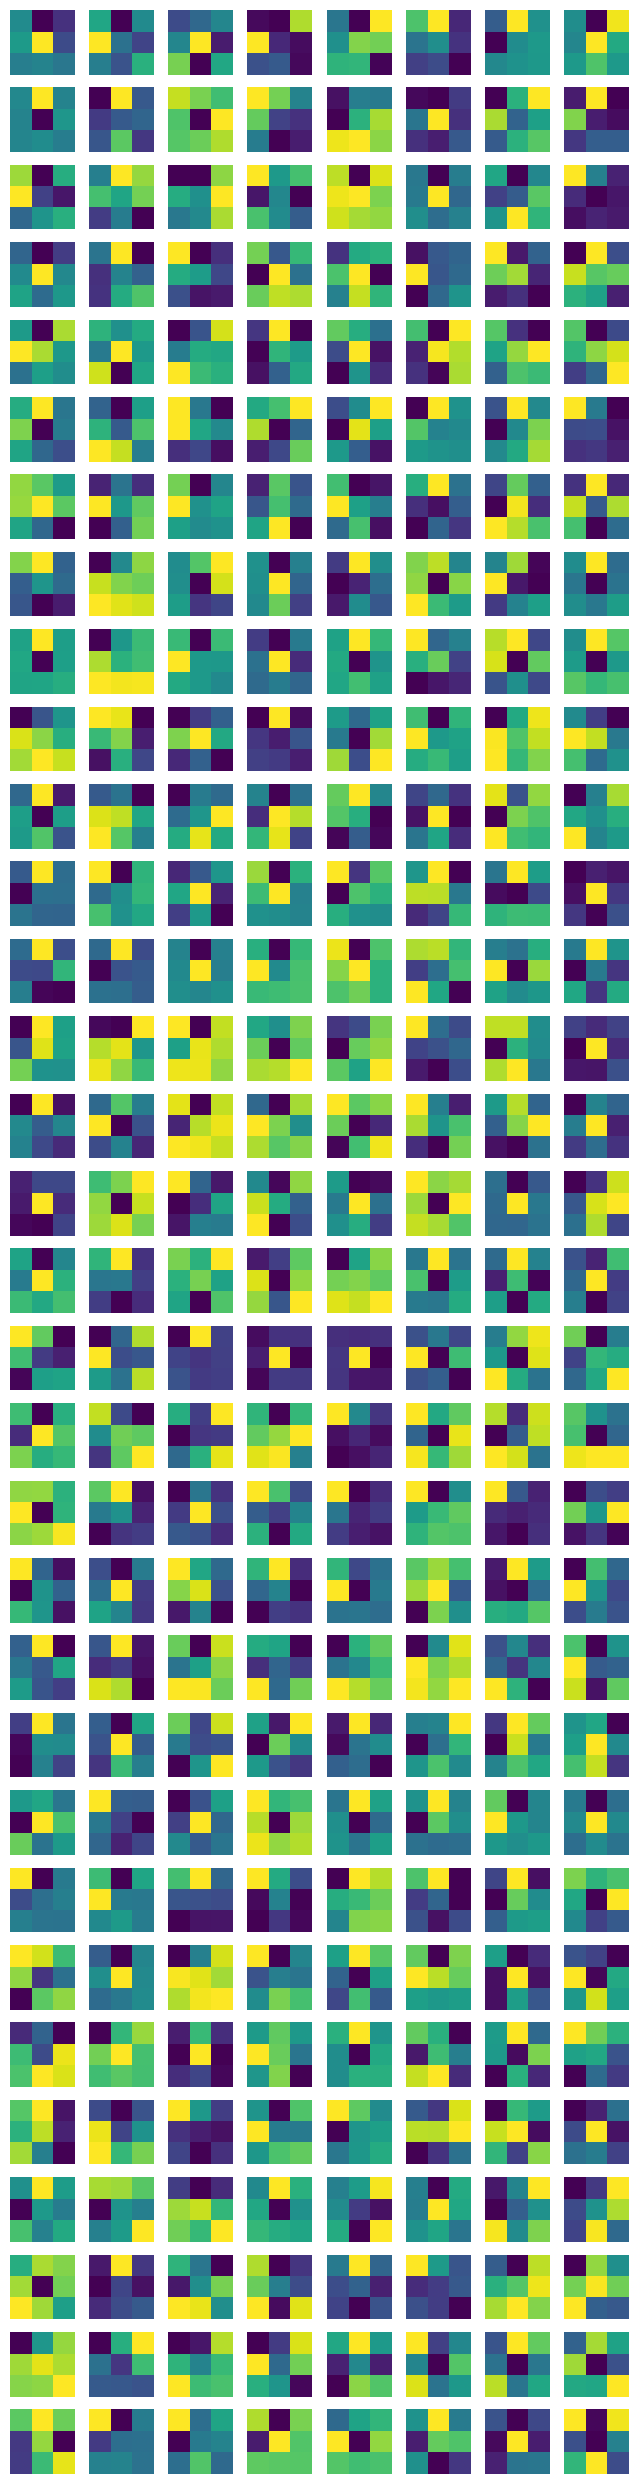

Layer: conv2d_12, Weight Magnitude: 33.5884


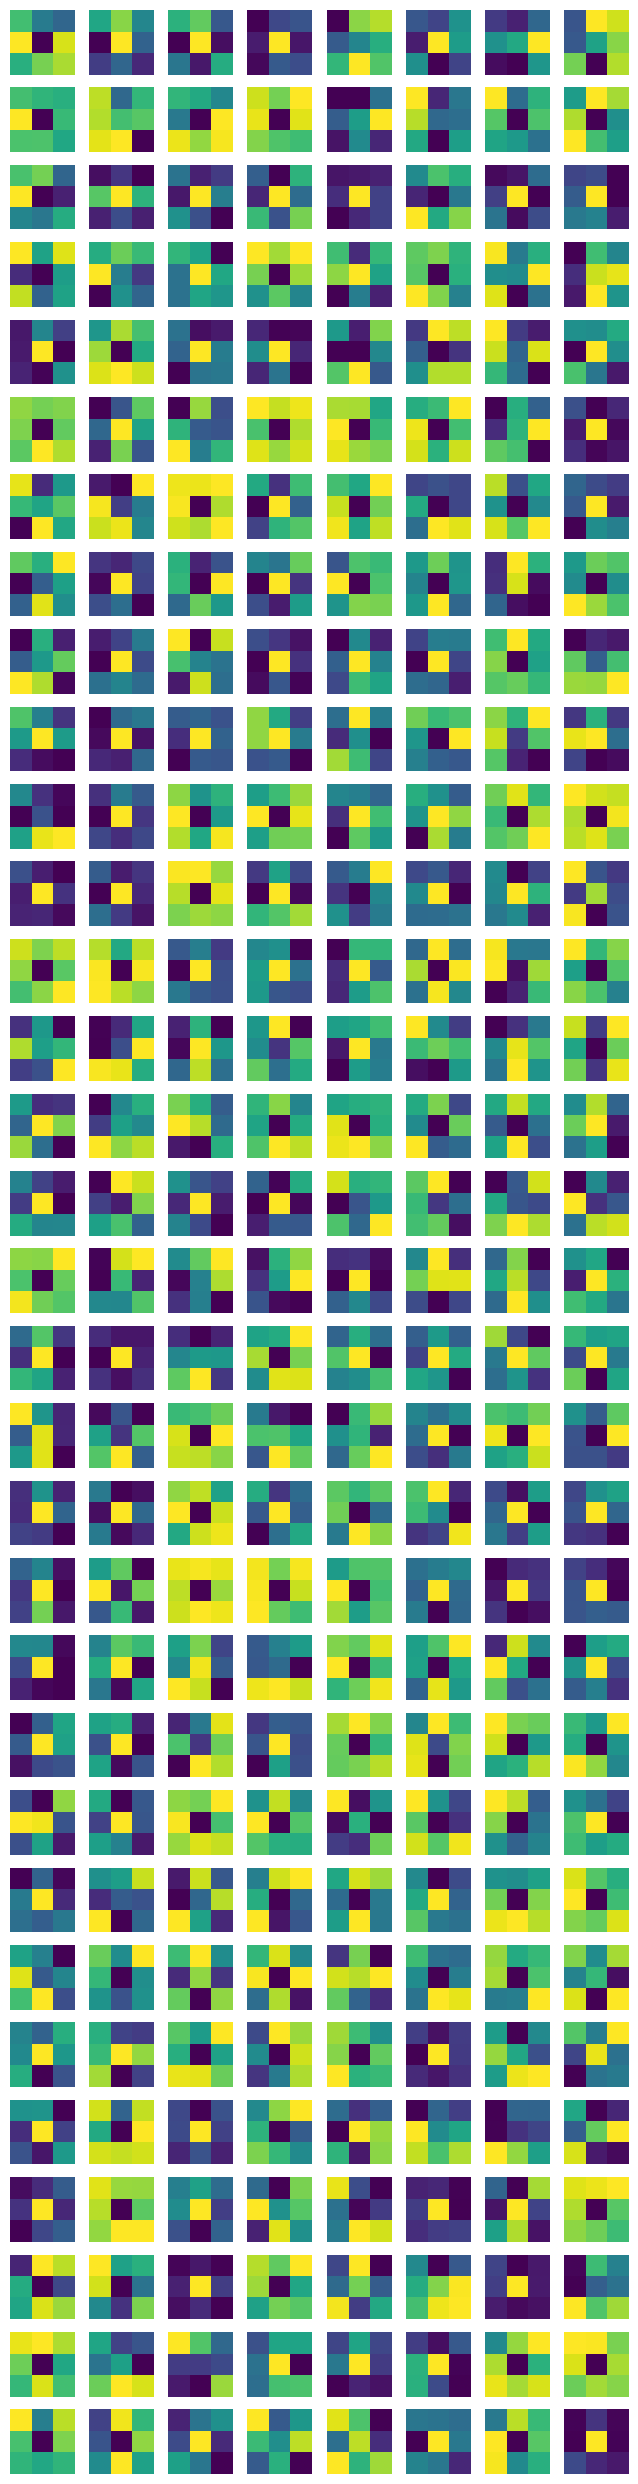

Layer: conv2d_13, Weight Magnitude: 27.8653


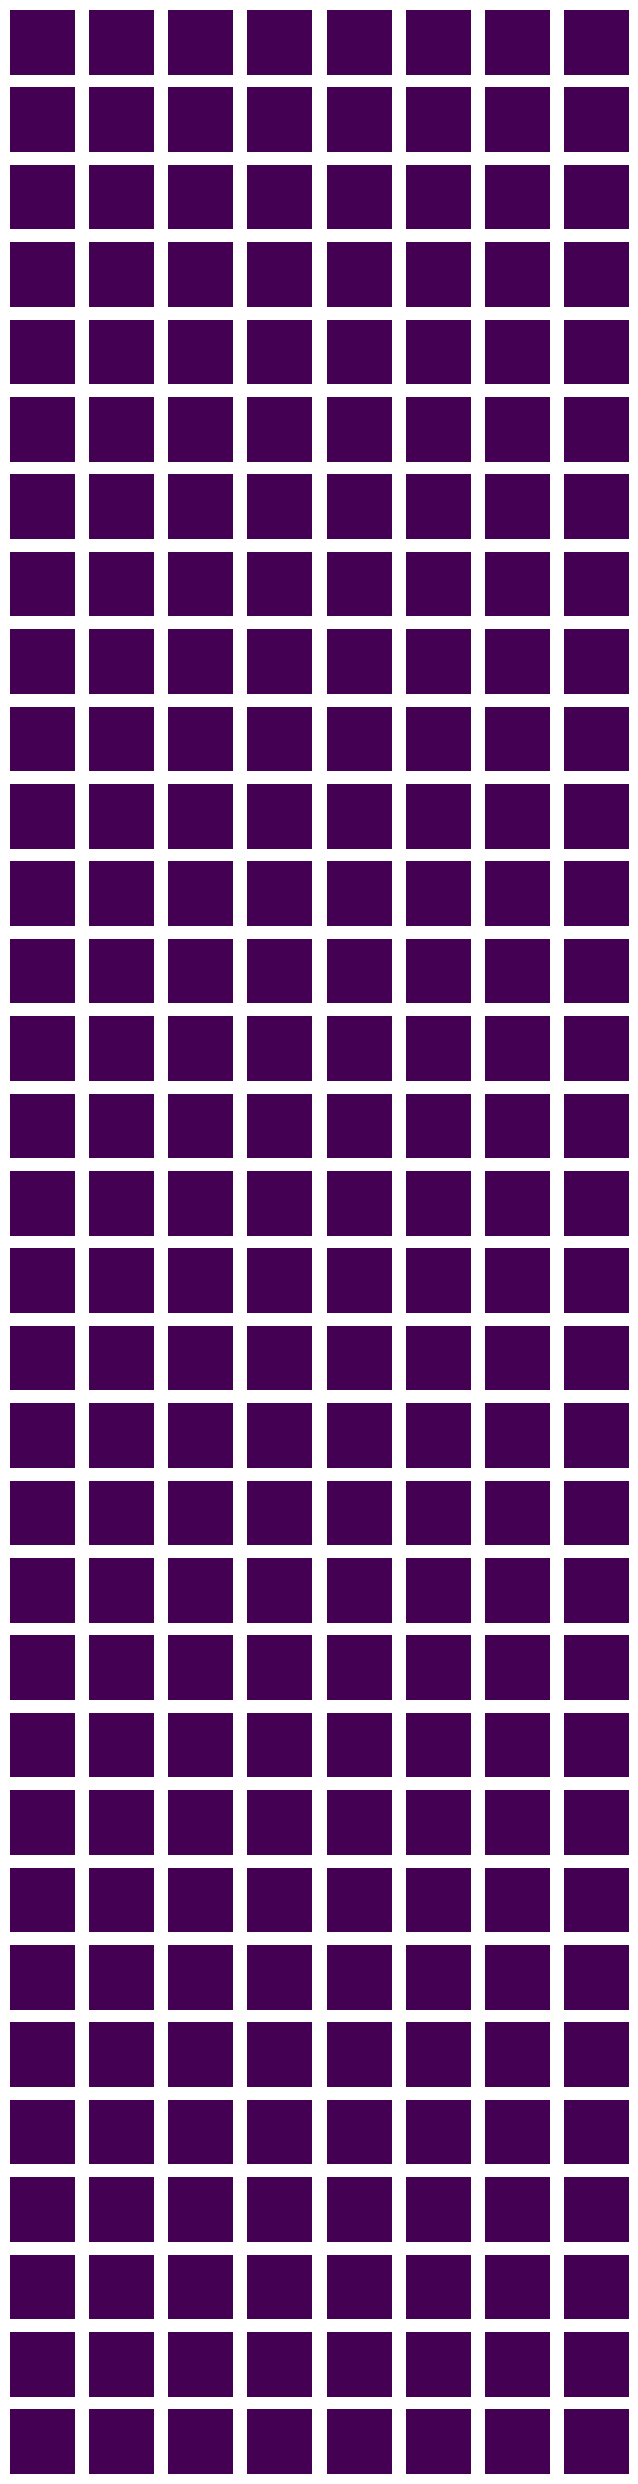

Layer: conv2d_14, Weight Magnitude: 26.2575


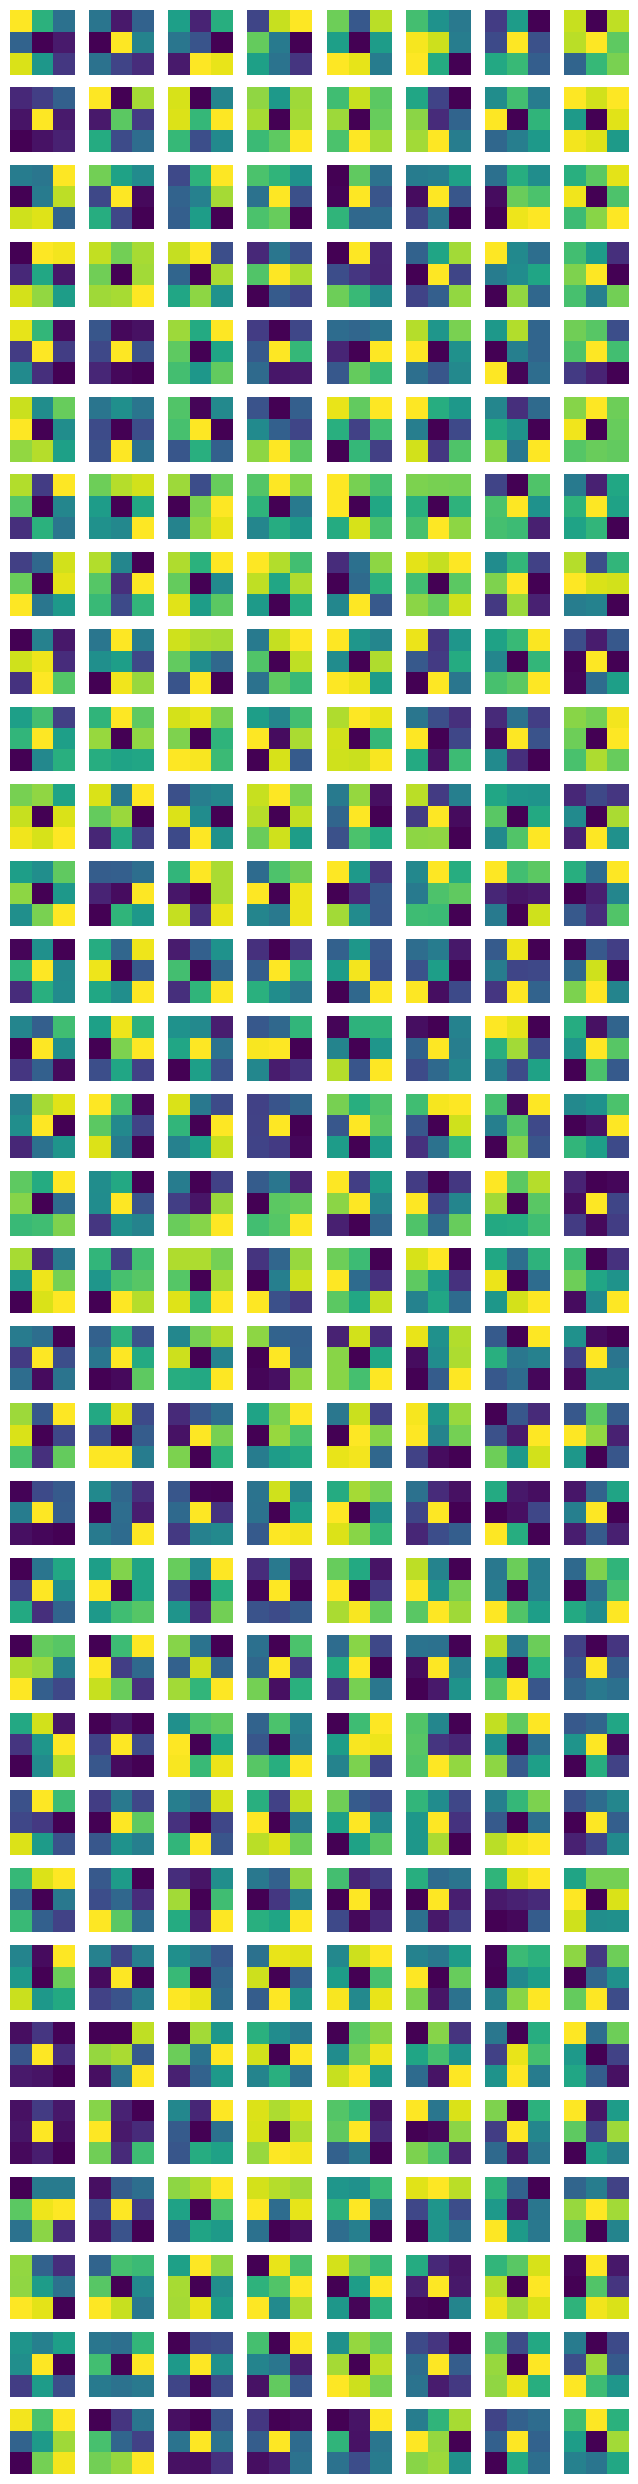

Layer: conv2d_15, Weight Magnitude: 20.7704


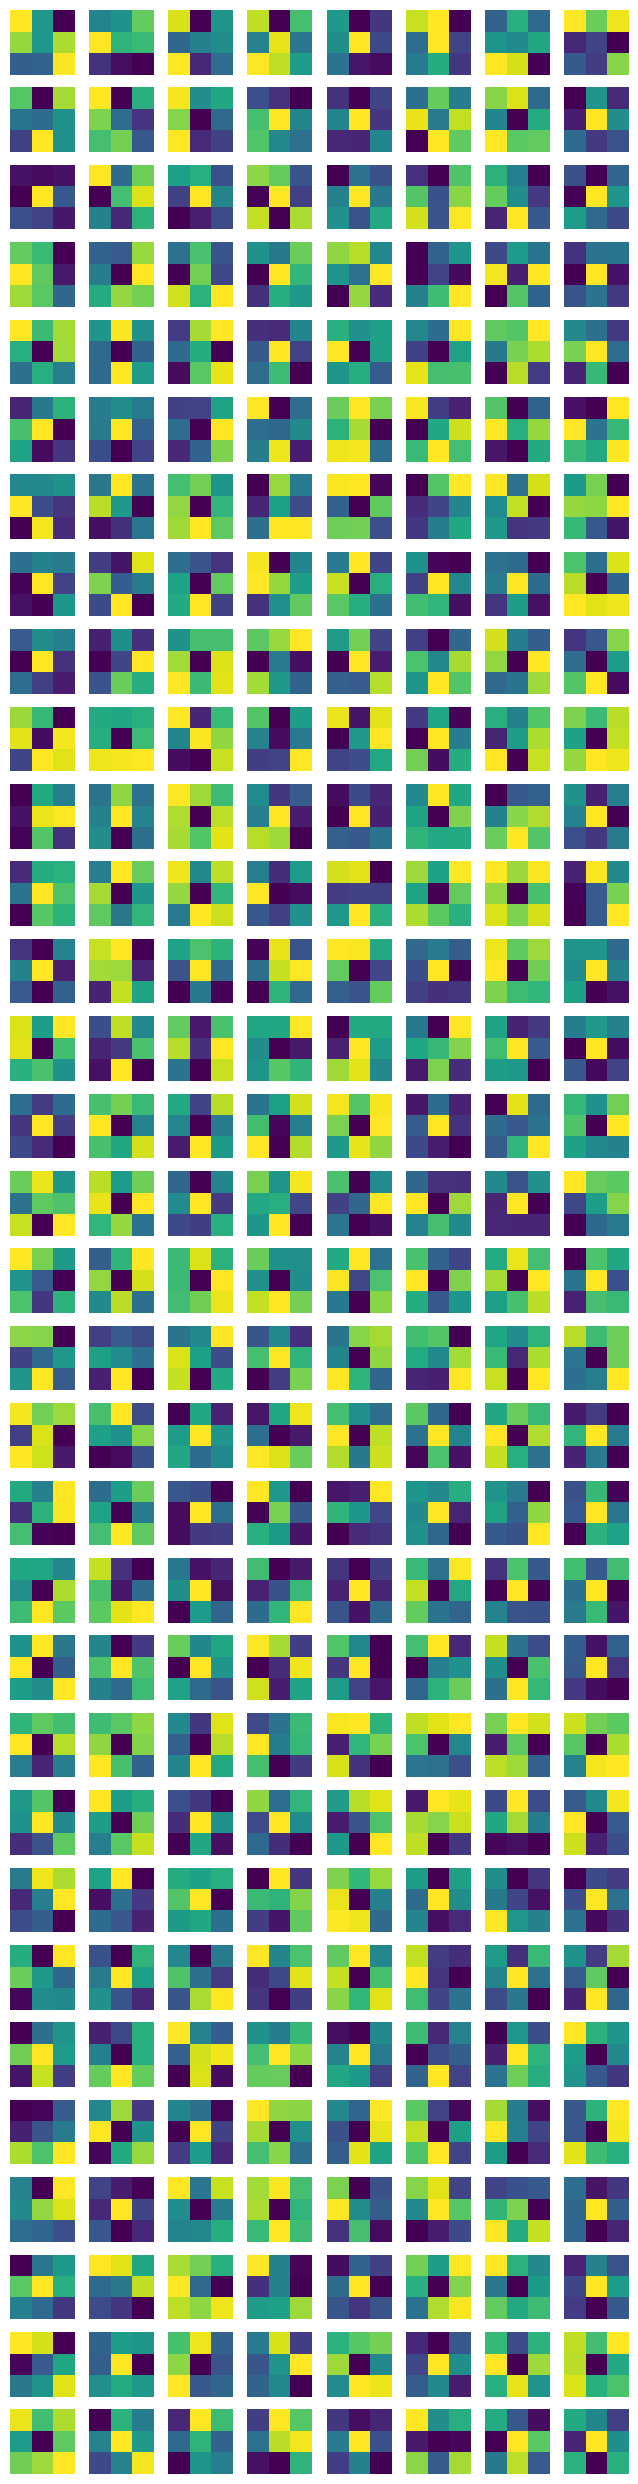

Layer: conv2d_16, Weight Magnitude: 20.5416


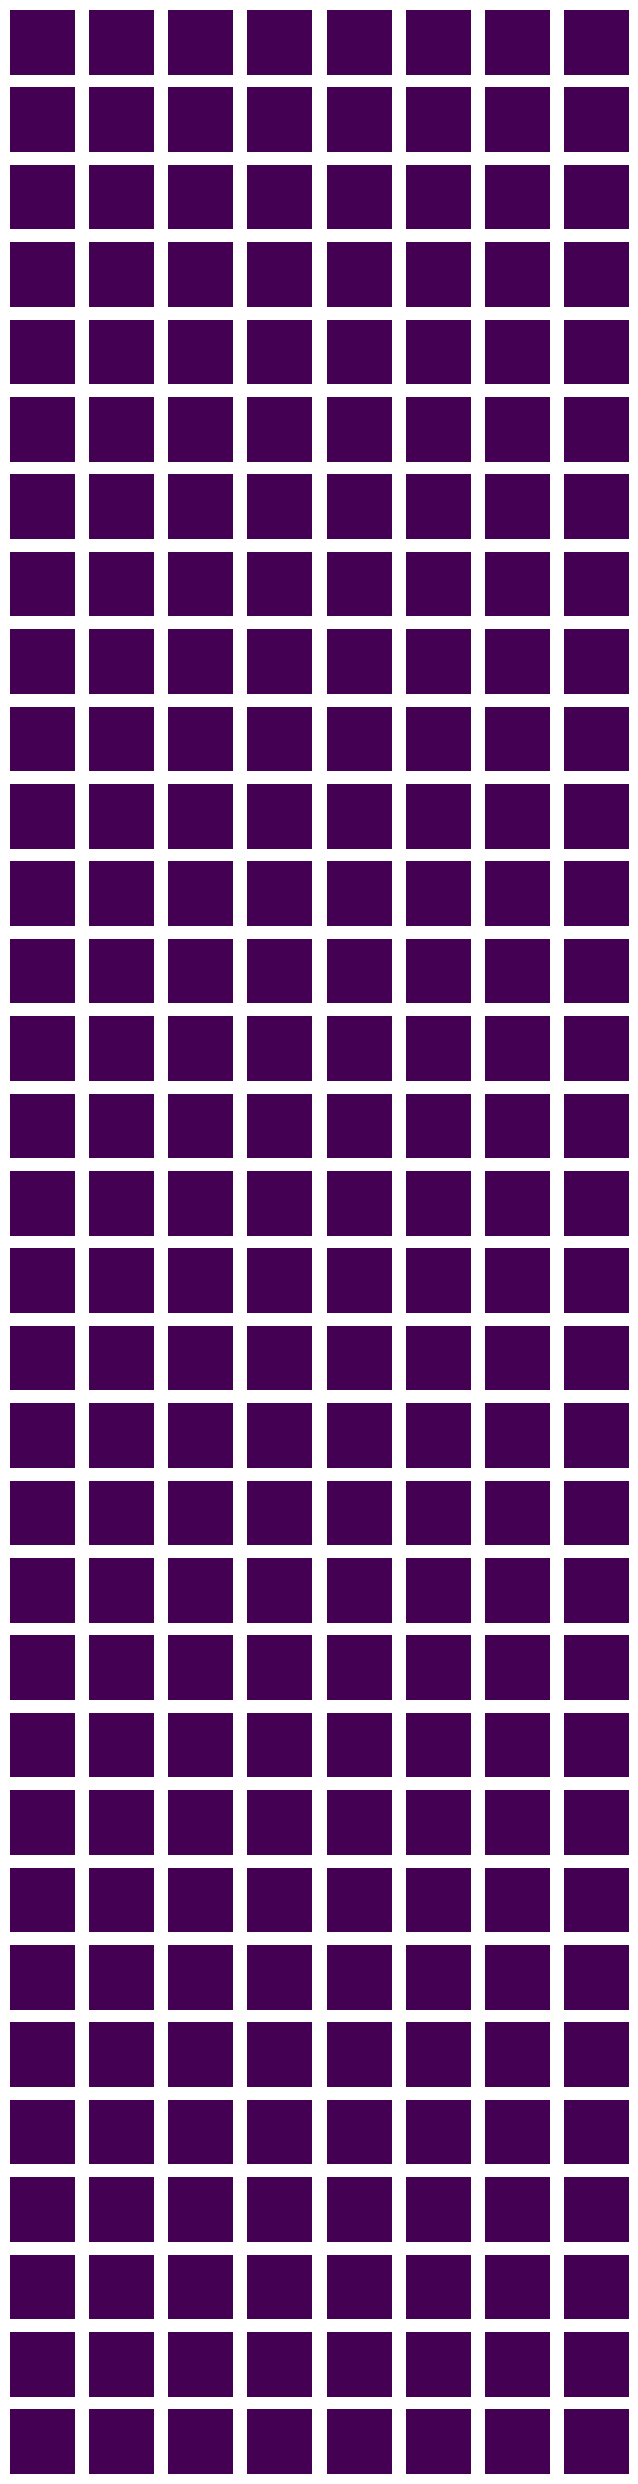

Layer: conv2d_17, Weight Magnitude: 21.3776


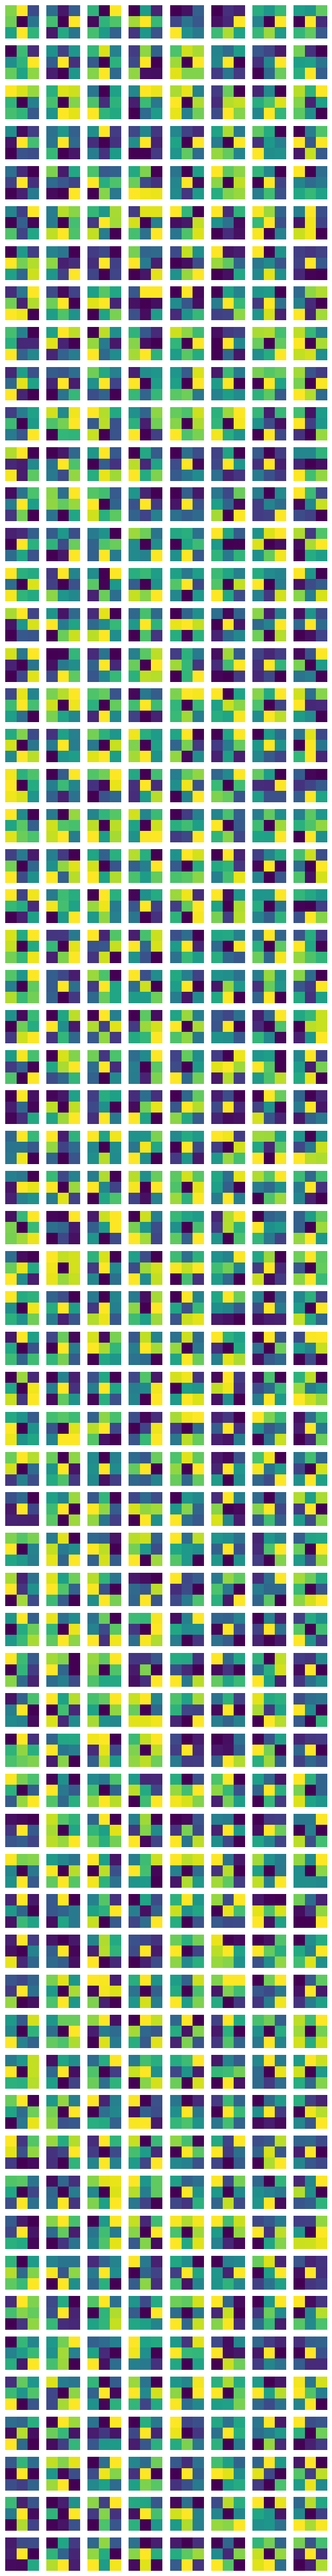

Layer: conv2d_18, Weight Magnitude: 24.3481


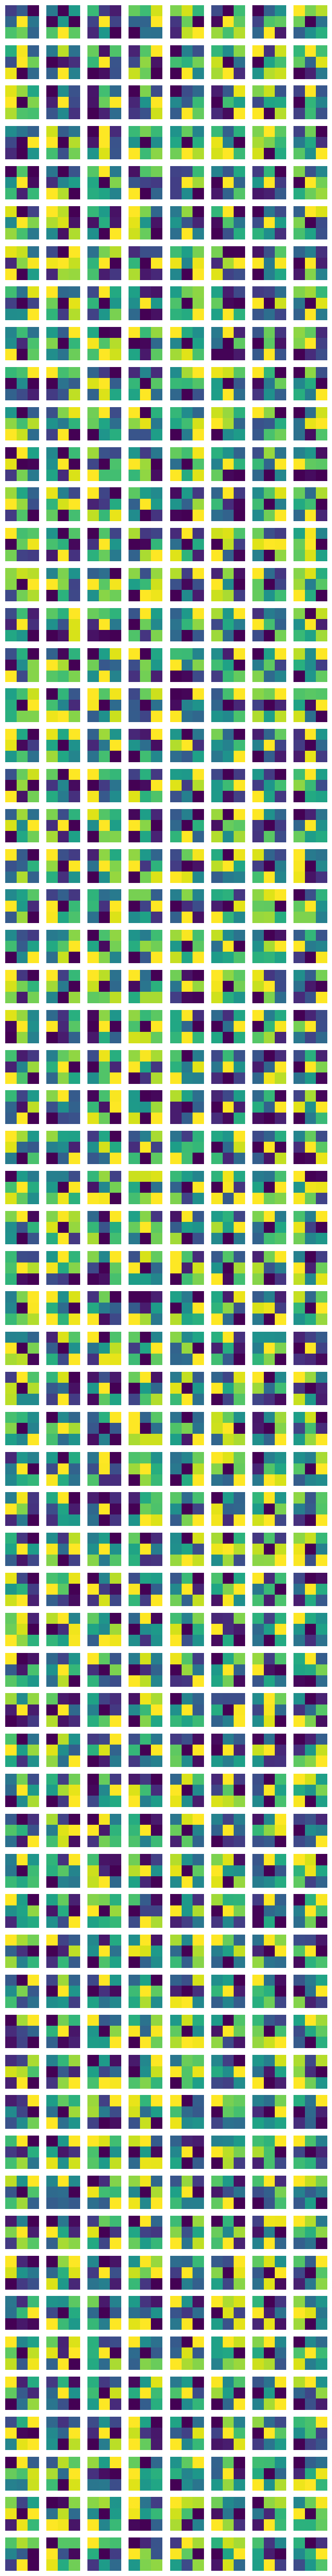

Layer: conv2d_19, Weight Magnitude: 20.0805


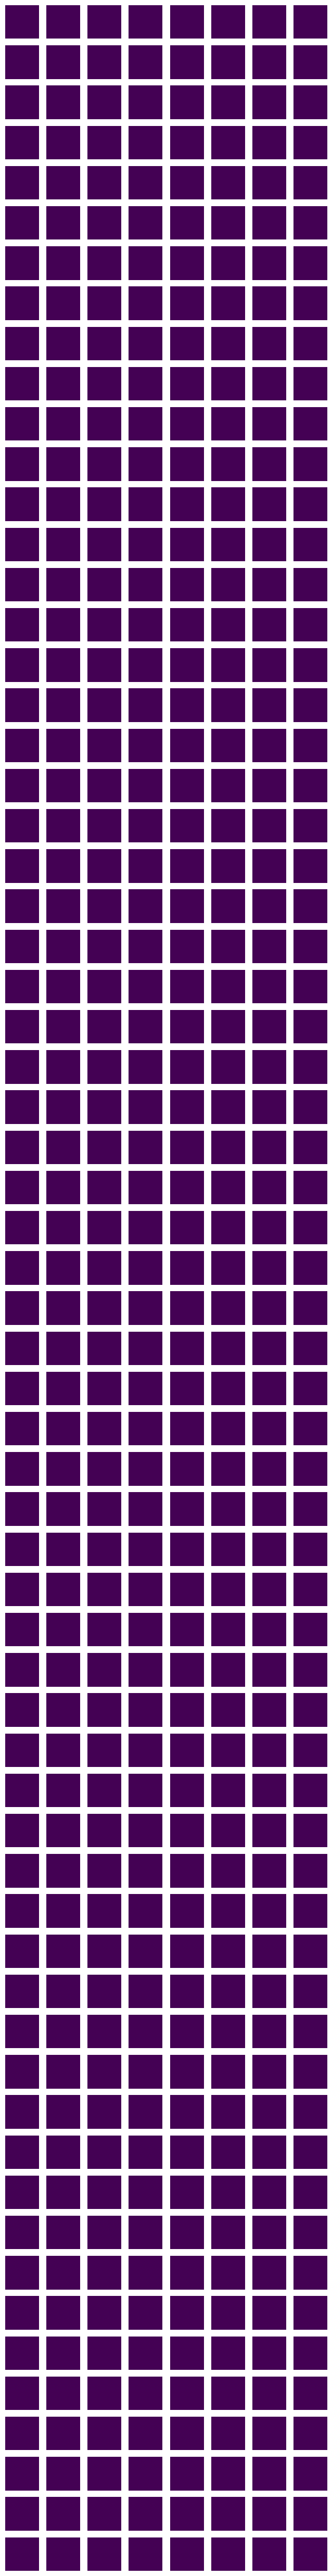

Layer: conv2d_20, Weight Magnitude: 23.4231


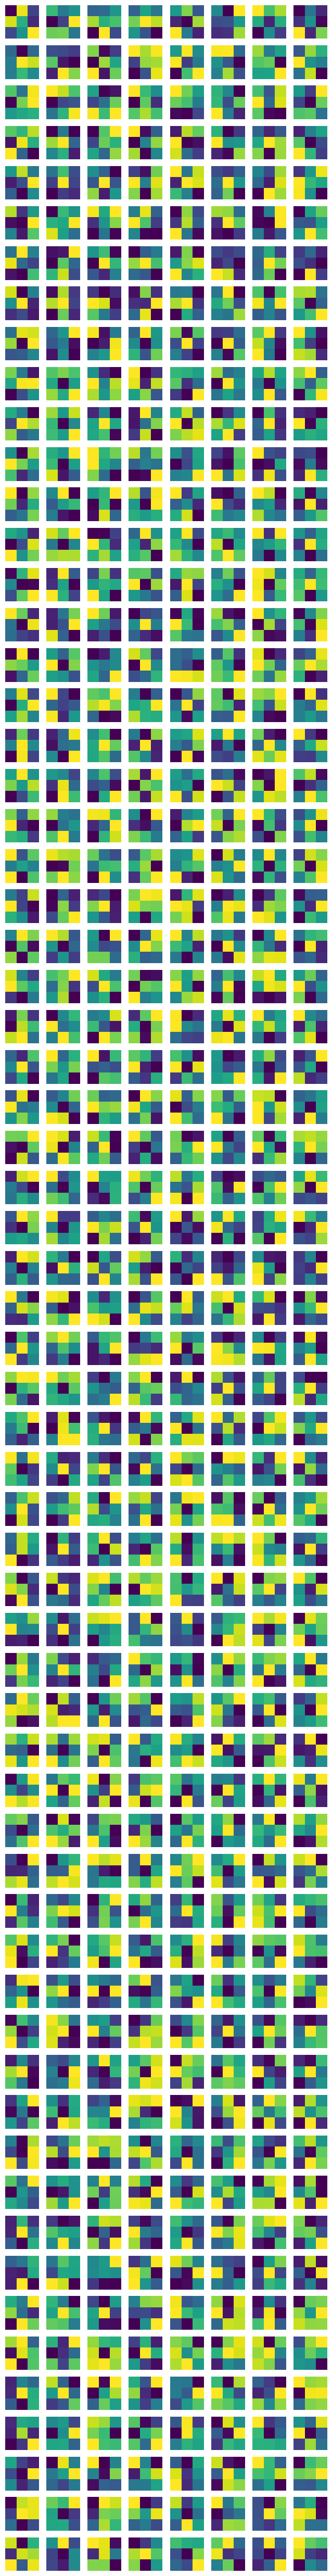

Layer: conv2d_21, Weight Magnitude: 23.1130


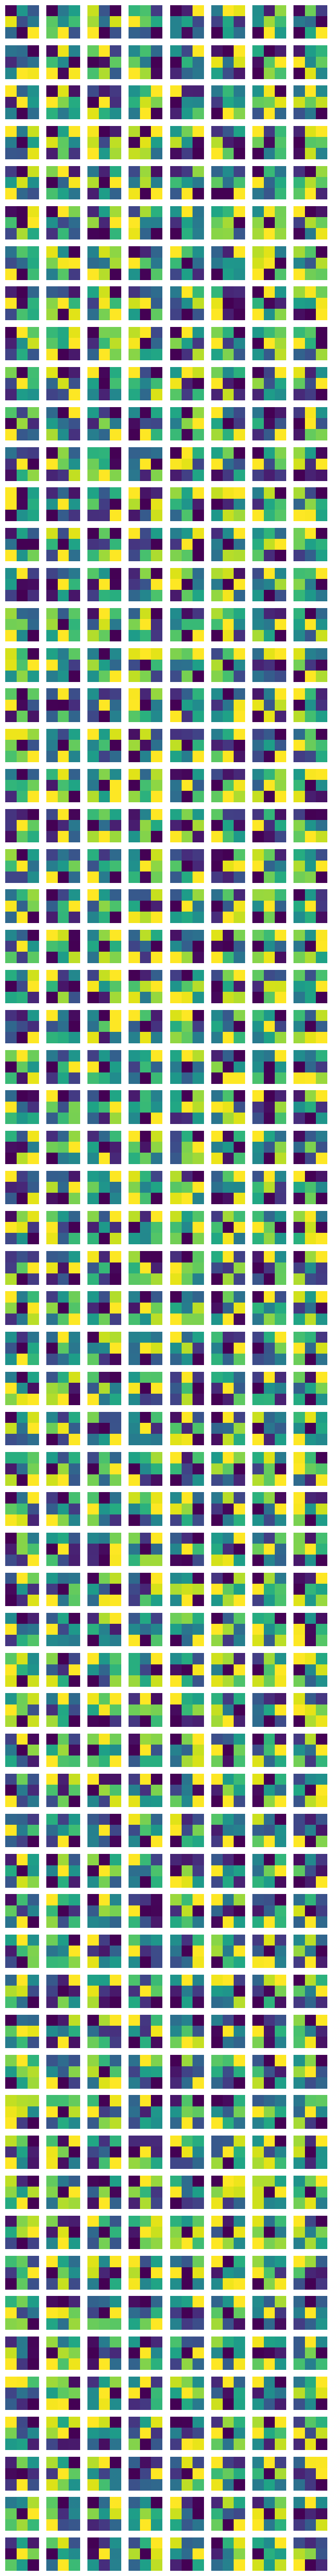

Layer: conv2d_22, Weight Magnitude: 23.3586


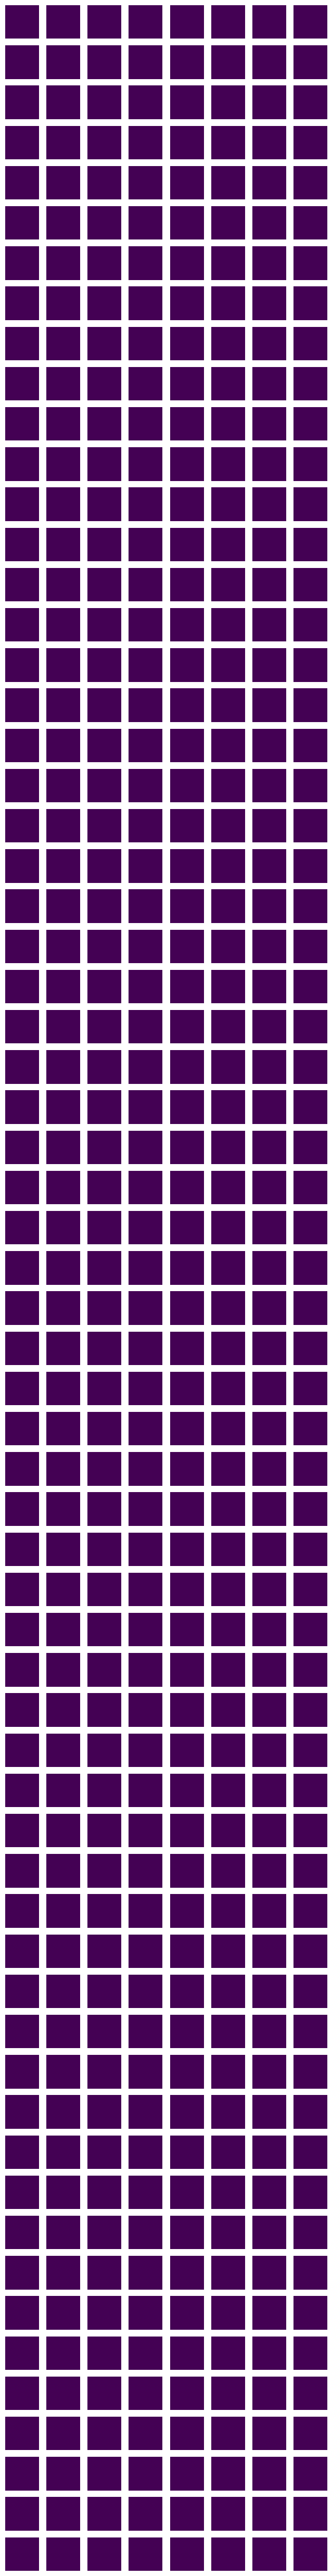

In [7]:
# Print Weights and Plot Kernels for Convolutional Layers
for layer in model.layers:
    if isinstance(layer, layers.Conv2D):
        weights = layer.get_weights()[0]
        print(f"Layer: {layer.name}, Weight Magnitude: {np.linalg.norm(weights):.4f}")

        # Plot kernels for the current layer
        num_kernels = weights.shape[3]
        num_cols = 8
        num_rows = (num_kernels + num_cols - 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
        for i, ax in enumerate(axes.flat):
            if i < num_kernels:
                ax.imshow(weights[:, :, 0, i], cmap='viridis')
                ax.axis('off')
        plt.show()